###  **This is a pretty long tutorial and I know how hard it is to go through, hopefully you may skip a few blocks of code if you need**

One of the oldest problem in Statistics is to deal with unbalanced data, for example, surviving data, credit risk, fraud. 

Basically in any data where either your success rate is too high or too low, models are almost irrelavant. This comes from the fact that we use a criteria around 1% to measure the accuracy of a model, ie, if my model predicts in the testing set 99% of the success (or failure depending on what you are trying to do), the model is a hero.

![title](images.png)

What happens with unbalanced data is that the success metric happening in around 1% (usually less than 10%), so if you have no model and predicts success at 1%, then the model passes the accuracy criteria.

In this post you will learn a 'trick' to deal with this type of data: *oversampling* and *undersampling*.
In this project I will skip the descriptive analysis hoping that we all want to focus on fraud analysis a bit more.


# Importing Libraries

In an early stage we will use a few of the most popular libraries such as pandas, numpy, matplotlib, sklearn, but also some for this particular type of problem such as imblearn, mlxtend and my favorite for logistic regression statsmodels.


In [85]:
#import libraries

#to plot stuff
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scikitplot as skplt
import numpy as np


#decision tree
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

#split training and testing
from sklearn.model_selection import train_test_split

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#model evaluation
from sklearn.metrics import confusion_matrix

#decision tree plotter
from mlxtend.plotting import category_scatter
from mlxtend.plotting import plot_decision_regions

import statsmodels.api as sm


# Data Problem and Motivation

I have been working on a similar problem at work and I could not find a good source of information with I wanted. I knew I had to perform unbalanced data treatment and I wanted to use Logistic Regression and so I had to pick parts of code around and sew them together myself (thus this blog post).

The data used here was available in a kaggle competition 2 years ago in this link: https://www.kaggle.com/mlg-ulb/creditcardfraud. I have no extra knowledge of the data or data source whatsoever besides what is already in there. They do mention in the data description that a PCA analysis was performed and unfortunately, due to the nature of the business and privacy, they cannot release any additional information on the dataset.

This is what the data looks like:


In [42]:
#loads data
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Factoring the X matrix for Regression
If we take a closer look at the amount of success and failure in the original data, we have:

In [84]:
#define our original variables
y = df['Class']
features =list(df.columns[1:len(df.columns)-1])
X = pd.get_dummies(df[features], drop_first=True)

p = sum(y)/len(y)
print("Percentage of Fraud: "+"{:.3%}".format(p));

Percentage of Fraud: 0.173%


Now we know how low is the probability of a fradulent transactions to happen in our dataset (which here it will be treated as our success event). 

# Separating Test and Training
Let's separate the data in training and testing

In [56]:
#define training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


p_test = sum(y_test)/len(y_test)
p_train = sum(y_train)/len(y_train)

print("Percentage of Fraud in the test set: "+"{:.3%}".format(p_test))
print("Percentage of Fraud in the train set: "+"{:.3%}".format(p_train))


Percentage of Fraud in the test set: 0.172%
Percentage of Fraud in the train set: 0.173%


This way the percentage of success was kept within the split. 

Now because of our unbalanced data we need the dataset to have balanced success rate in order to validate the model. There are two ways of doing it: 
* Oversampling: which is basically floading the dataset with success events in a way that the percentage of success is closer to 50% (balanced) then the original set.
* Undersampling: which is reducing the unbalanced event, forcing the dataset to be balanced.

## Method: Over Sampling

First let's perform the Oversampling analysis:

In [87]:
#oversampling
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)

ros = RandomUnderSampler(random_state=42)
X_under, y_under = ros.fit_resample(X_train, y_train)

#write oversample dataframe as a pandas dataframe and add the column names
#column names were removed from the dataframe when we performed the oversampling
#column names will be useful down the road when we do a feature selection

X = pd.DataFrame(X)
names = list(X.columns)
X_over = pd.DataFrame(X_over)
X_over.columns = names

X_under = pd.DataFrame(X_under)
X_under.columns = names

p_over = sum(y_over)/len(y_over)
p_under = sum(y_under)/len(y_under)

print("Percentage of Fraud in the test set: "+"{:.3%}".format(p_over))
print("Percentage of Fraud in the train set: "+"{:.3%}".format(p_under))

Percentage of Fraud in the test set: 50.000%
Percentage of Fraud in the train set: 50.000%


Now the data has the same amount of success and failures.

# Modeling with Logistic Regression

In the snipped of code below we have three function:

1. **remove_pvalues():** a function to perform feature selection. It removes features with a p-value higher than 5%, which is basically the probability of the weight for that feature being equal 0. In a regression fitting, the coefficients pvalue test if each individual feature is irrelevant for the model (null hypothesis) or otherwise (alternative hypothesis). If you want to know more the Wikipedia article on p-value is pretty reasanable (https://en.wikipedia.org/wiki/P-value)

<br>

2. **stepwise_logistic():** now we will repeat the process of removing the "irrelavant features" until there is no more fetaures to be removed. This function will loop through the model interactions until stops removing features.

<br>

3. **logit_score():** The output of a logistic regression model is actually a vector of probabilities from 0 to 1, the closer to 0 the more unlikely is of that record to be a fraud given the current variables in the model. And on another hand the closer to 1, the more likely is to be a fraud. For the purposes of this problem, if the probability is higher than 0.95 (which it was picked by me randomly and guttely speaking) I am calling that a 1. And then at the end, this function scores the predicted success rate against the real value of the testing set.

Note: The IMO the threshold to call a fraud or success depends on how many false negative/positive you are willing to accept. In statistics, it's impossible to control both at the same time, so you need to pick and choose.

In [88]:
#the functione below perform the stepwise selection using backward method based on feature weight
#this functionality is not created in python (specially for logistic regression)
#the first function removes coefficients with high p-values
#the second function repeats the first procedure until the number of features stops changing
#the third function scores the model rounding likelihood higher than  0.95 to 1 (assuming it's a fraud)

def remove_pvalues(my_list, alpha=0.05):
    #function to remove high p-value coefficients
    #basically the p-value tests the probability of a coeficient having 0 effect which it could be caused by collinearity
    # we want to remove that because it affects the quality of the model

    features = []
    counter = 0
    
    for item in my_list:
        if my_list.iloc[counter]<=alpha:
            features.append(my_list.index[counter])

        counter+=1
    
    return features


def stepwise_logistic(X_res, y_res):
    
    #function to perform the logistic regression until the change in the coefficients is 0
    lr=sm.Logit(y, X)
    lr = lr.fit()
    my_pvalues = lr.pvalues
    features = remove_pvalues(my_pvalues)
    n_old = len(features)
    
    while True:
        X_new = X_res[features]
        lr=sm.Logit(y_res,X_new)
        lr = lr.fit()
        new_features = remove_pvalues(lr.pvalues)
        n_new = len(new_features)
        if n_old- n_new==0:
            break
        else: 
            n_old = n_new


    return new_features

def logit_score(model, X, y, threshold=0.95):
    #function to score the logit model (only works for models that support .predict function)
    y_t = model.predict(X)
    y_t = y_t > threshold
    z= abs(y_t-y)
    score = 1- sum(z)/len(z)
    return score
    

## Performing Logistic Regression
Now our guns are loaded, we just need to fire, below I am performing the feature selection and then the model fitting in the final X matrix:

In [89]:
#execute the functions above

features = stepwise_logistic(X_over, y_over)
X_over_new = X_over[features]

lr=sm.Logit(y_over,X_over_new)
lr = lr.fit()
   

Optimization terminated successfully.
         Current function value: 0.021744
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.209580
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.209580
         Iterations 14


## Scoring the model
Now the most expected part of this tutorial, which is basically checking how many "rights and wrongs" we are getting, considering the model was created based on a dataset with a 50% of fraud occurrences, and then tested in a set with 0.17% of fraud occurrences.<br>
**Voila:**

In [90]:

score = logit_score(lr, X_test[features], y_test)
y_t = lr.predict(X_test[features])
#rounds to 1 any likehood higher than 0.95, otherwise sign 0
y_t = y_t > 0.95

print("Percentage of Rights and Wrongs in the testing set "+"{:.3%}".format(score));


Percentage of Rights and Wrongs in the testing set 99.261%


In [91]:
#from the number below you can see if the model is over or under predicting
print('Number of Frauds in real data %s' % sum(y_test))
print('Number of Frauds in prediction data %s' % sum(y_t))

Number of Frauds in real data 98
Number of Frauds in prediction data 491


Now that we know the model is awesome, let's see where we are getting it wrong. The plot below shows how many false negatives and false positives we have. We see a lot more false positives (we are saying a transaction was fradulent even though it was not). This come from the 0.95 threeshold above, if you increase that value to 0.99 for example, you will increase the amount of false begatives as well. The statstician need to decide what is the optimum cut.


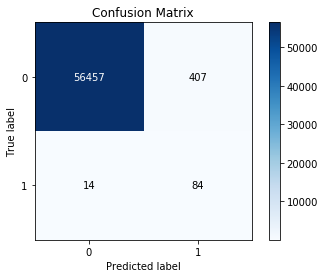

In [72]:
#plots confusion matrix with false positives and negatives
skplt.metrics.plot_confusion_matrix(y_test, y_t)

let's see what variables are more important to the model in asbolute value. In the chart below you can see the top 15 most relavant features:

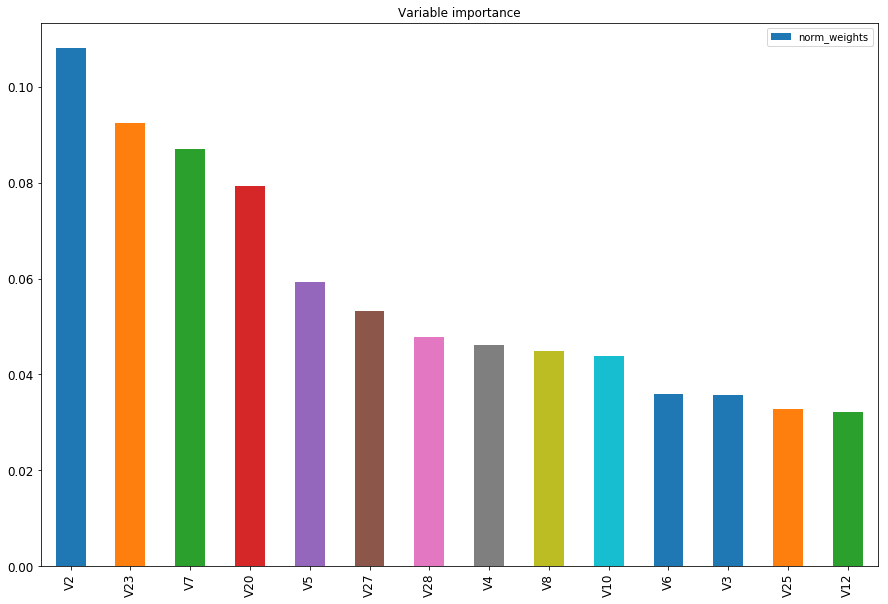

In [17]:
#calculate the weights
weights = lr.params

#creates a dataframe for them and the coefficient names
importance_list = pd.DataFrame(
    {'names': features,
     'weights': weights
    })

#normalized absolute weights
importance_list['abs_weights'] = np.abs(importance_list['weights'])
total = sum(importance_list['abs_weights'])
importance_list['norm_weights'] = importance_list['abs_weights']/total

#select top 10 with higher importance
importance_list = importance_list.sort_values(by='norm_weights', ascending=False)
importance_list = importance_list.iloc[0:14]

#plot them tcharam!
ax = importance_list['norm_weights'].plot(kind='bar', title ="Variable importance",figsize=(15,10),legend=True, fontsize=12)
ax.set_xticklabels(importance_list['names'], rotation=90)

plt.show()

Now to visualize the weights we can see in the plot below which variables decrease x increase the likelihood of having a fradulent transaction. 

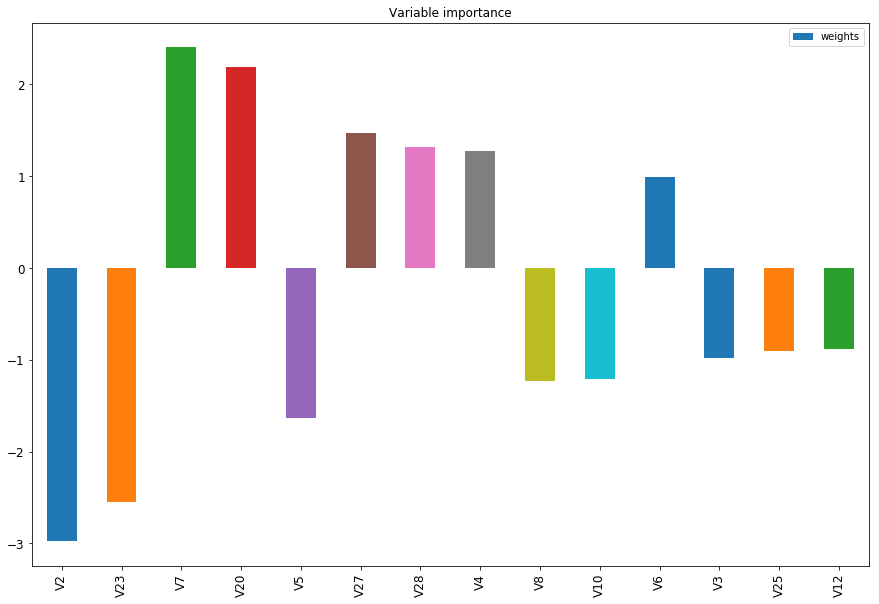

In [18]:
ax = importance_list['weights'].plot(kind='bar', title ="Variable importance",figsize=(15,10),legend=True, fontsize=12)
ax.set_xticklabels(importance_list['names'], rotation=90)

plt.show()

In [ ]:
I know this is a pretty long tutorial but hopefully you will not need to go through all the yak shaving I had to go through what I went through.